Preproceesing news and stock data

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
import re
import codecs

In [2]:
def decode_unicode_escapes(text):
    """Decode escaped Unicode sequences like \\u2026, \\u2019, etc."""
    if isinstance(text, str):
        try:
            return codecs.decode(text, 'unicode_escape')
        except Exception:
            return text
    return text

def clean_text(text):
    """Decode Unicode + normalize spacing and punctuation."""
    text = decode_unicode_escapes(text)
    text = re.sub(r"\s+", " ", text)        # normalize multiple spaces
    text = re.sub(r"\.{3,}", "...", text)   # collapse multiple dots
    text = re.sub(r"\s+([?.!,])", r"\1", text)  # remove space before punctuation
    return text.strip()

In [3]:
def preprocess_news(file_path, company_name, save_path):
    df = pd.read_json(file_path)

    # Drop unnecessary columns (keep what's useful)
    cols_to_drop = ["url", "image"]
    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

    # Parse and simplify date
    df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce").dt.date
    df.sort_values("published_at", inplace=True)

    # Combine title and description for text analysis
    df["combined_text"] = (df["title"].fillna("") + ". " + df["description"].fillna("")).str.strip()

    # Remove duplicates based on text + date
    df.drop_duplicates(subset=["combined_text", "published_at"], inplace=True)

    # Add company label
    df["company"] = company_name

    # Save if path is given
    if save_path:
        # explicitly set UTF-8 encoding when saving
        with open(save_path, "w", encoding="utf-8") as f:
            df.to_json(f, orient="records", indent=4, date_format="iso", force_ascii=False)
        print(f"✅ Saved cleaned file for {company_name}: {save_path}")

    return df

In [5]:
df_infosys = preprocess_news(
    "D:/5TH SEM/stock_sentiment_project/data/raw/news/infosys.json", 
    "Infosys", 
    "D:/5TH SEM/stock_sentiment_project/data/preprocessed/news/clean_infosys.json"
)

df_sbi = preprocess_news(
    "D:/5TH SEM/stock_sentiment_project/data/raw/news/sbi.json", 
    "SBI", 
    "D:/5TH SEM/stock_sentiment_project/data/preprocessed/news/clean_sbi.json"
)

df_reliance = preprocess_news(
    "D:/5TH SEM/stock_sentiment_project/data/raw/news/reliance.json", 
    "Reliance", 
    "D:/5TH SEM/stock_sentiment_project/data/preprocessed/news/clean_reliance.json"
)


✅ Saved cleaned file for Infosys: D:/5TH SEM/stock_sentiment_project/data/preprocessed/news/clean_infosys.json
✅ Saved cleaned file for SBI: D:/5TH SEM/stock_sentiment_project/data/preprocessed/news/clean_sbi.json
✅ Saved cleaned file for Reliance: D:/5TH SEM/stock_sentiment_project/data/preprocessed/news/clean_reliance.json


In [6]:
df_industry = preprocess_news(
    "D:/5TH SEM/stock_sentiment_project/data/processed/sbi-industry.json", 
    "Banking Industry", 
    "D:/5TH SEM/stock_sentiment_project/data/processed/news/clean_sbi_industry.json"
)

✅ Saved cleaned file for Banking Industry: D:/5TH SEM/stock_sentiment_project/data/processed/news/clean_sbi_industry.json


In [2]:
def load_stock_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    df = df.fillna(method='ffill').fillna(method='bfill')
    df = df.dropna(subset=['Open', 'Close', 'High', 'Low'])
    return df

In [3]:
def add_basic_features(df):
    df['Daily_Return_%'] = (df['Close'] - df['Open']) / df['Open'] * 100
    df['Intraday_Volatility_%'] = (df['High'] - df['Low']) / df['Open'] * 100
    df['Prev_Close'] = df['Close'].shift(1)
    df['Price_Change'] = df['Close'] - df['Prev_Close']
    return df

In [4]:
def add_technical_indicators(df):
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()

    df['Rolling_Volatility_5'] = df['Close'].pct_change().rolling(window=5).std() * 100
    df['Rolling_Volatility_20'] = df['Close'].pct_change().rolling(window=20).std() * 100

    # RSI Calculation
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    return df


In [5]:
def add_target_labels(df):
    df['Target'] = np.sign(df['Daily_Return_%'])
    df['Target'] = df['Target'].replace(0, np.nan).fillna(method='ffill')
    return df

In [16]:
#preprocessing + feature engineering pipeline
def preprocess_stock_file(file_path, company_name, save_path):
    print(f"Processing {company_name}...")
    
    df = load_stock_data(file_path)
    df = add_basic_features(df)
    df = add_technical_indicators(df)
    df = add_target_labels(df)
    df['Company'] = company_name

    # Save if path is given
    if save_path:
        # explicitly set UTF-8 encoding when saving
        with open(save_path, "w", encoding="utf-8") as f:
            df.to_csv(f)
        print(f"Saved cleaned file for {company_name}: {save_path}")
    return df

In [17]:
df_inf_stock = preprocess_stock_file( "D:/5TH SEM/stock_sentiment_project/data/raw/stocks/infosys_stock_history.csv", "Infosys", "D:/5TH SEM/stock_sentiment_project/data/processed/stock/clean_infosys_stock.csv")
df_inf_stock.head()

Processing Infosys...
Saved cleaned file for Infosys: D:/5TH SEM/stock_sentiment_project/data/processed/stock/clean_infosys_stock.csv


C:\Users\Hemant\AppData\Local\Temp\ipykernel_6488\3232159068.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\Hemant\AppData\Local\Temp\ipykernel_6488\759049456.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Target'] = df['Target'].replace(0, np.nan).fillna(method='ffill')


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return_%,Intraday_Volatility_%,Prev_Close,Price_Change,MA_5,MA_20,Rolling_Volatility_5,Rolling_Volatility_20,RSI_14,Target,Company
0,2025-06-01 18:30:00+00:00,1536.478294,1536.478294,1515.794933,1530.371826,4374509,0.0,0.0,-0.397433,1.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,Infosys
1,2025-06-02 18:30:00+00:00,1535.493371,1543.668271,1512.446172,1519.734619,6853403,0.0,0.0,-1.026299,2.033359,1530.371826,-10.637207,NaN,NaN,NaN,NaN,NaN,-1.0,Infosys
2,2025-06-03 18:30:00+00:00,1519.734601,1533.819033,1518.158750,1527.810913,4548307,0.0,0.0,0.531429,1.030462,1519.734619,8.076294,NaN,NaN,NaN,NaN,NaN,1.0,Infosys
3,2025-06-04 18:30:00+00:00,1524.560733,1544.062116,1518.355677,1530.864258,6948539,0.0,0.0,0.413465,1.686154,1527.810913,3.053345,NaN,NaN,NaN,NaN,NaN,1.0,Infosys
4,2025-06-05 18:30:00+00:00,1531.258183,1545.244147,1519.833112,1540.221069,3960020,0.0,0.0,0.585328,1.659487,1530.864258,9.356812,1529.800537,NaN,NaN,NaN,NaN,1.0,Infosys


In [18]:
df_rel_stock = preprocess_stock_file( "D:/5TH SEM/stock_sentiment_project/data/raw/stocks/reliance_stock_history.csv", "Reliance", "D:/5TH SEM/stock_sentiment_project/data/processed/stock/clean_reliance_stock.csv")
df_rel_stock.head()

Processing Reliance...
Saved cleaned file for Reliance: D:/5TH SEM/stock_sentiment_project/data/processed/stock/clean_reliance_stock.csv


C:\Users\Hemant\AppData\Local\Temp\ipykernel_6488\3232159068.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\Hemant\AppData\Local\Temp\ipykernel_6488\759049456.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Target'] = df['Target'].replace(0, np.nan).fillna(method='ffill')


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return_%,Intraday_Volatility_%,Prev_Close,Price_Change,MA_5,MA_20,Rolling_Volatility_5,Rolling_Volatility_20,RSI_14,Target,Company
0,2025-06-01 18:30:00+00:00,1406.482683,1411.861226,1390.048320,1408.076294,8098668,0.0,0.0,0.113305,1.550883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Reliance
1,2025-06-02 18:30:00+00:00,1416.642154,1420.825398,1397.817314,1399.908936,11252626,0.0,0.0,-1.181189,1.624128,1408.076294,-8.167358,NaN,NaN,NaN,NaN,NaN,-1.0,Reliance
2,2025-06-03 18:30:00+00:00,1409.072238,1420.028480,1400.506474,1417.837280,8126827,0.0,0.0,0.622043,1.385451,1399.908936,17.928345,NaN,NaN,NaN,NaN,NaN,1.0,Reliance
3,2025-06-04 18:30:00+00:00,1422.319369,1448.913107,1417.936848,1436.662109,13716817,0.0,0.0,1.008405,2.177869,1417.837280,18.824829,NaN,NaN,NaN,NaN,NaN,1.0,Reliance
4,2025-06-05 18:30:00+00:00,1435.267636,1445.725866,1431.283548,1437.757690,8182161,0.0,0.0,0.173491,1.006246,1436.662109,1.095581,1420.048462,NaN,NaN,NaN,NaN,1.0,Reliance


In [19]:
df_sbi_stock = preprocess_stock_file( "D:/5TH SEM/stock_sentiment_project/data/raw/stocks/sbi_stock_history.csv", "SBI", "D:/5TH SEM/stock_sentiment_project/data/processed/stock/clean_sbi_stock.csv")
df_sbi_stock.head()

Processing SBI...
Saved cleaned file for SBI: D:/5TH SEM/stock_sentiment_project/data/processed/stock/clean_sbi_stock.csv


C:\Users\Hemant\AppData\Local\Temp\ipykernel_6488\3232159068.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\Hemant\AppData\Local\Temp\ipykernel_6488\759049456.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Target'] = df['Target'].replace(0, np.nan).fillna(method='ffill')


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return_%,Intraday_Volatility_%,Prev_Close,Price_Change,MA_5,MA_20,Rolling_Volatility_5,Rolling_Volatility_20,RSI_14,Target,Company
0,2025-06-01 18:30:00+00:00,812.849976,822.549988,809.200012,813.650024,26891575,0.0,0.0,0.098425,1.642366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,SBI
1,2025-06-02 18:30:00+00:00,816.200012,818.400024,805.150024,809.799988,14247597,0.0,0.0,-0.784125,1.623377,813.650024,-3.850037,NaN,NaN,NaN,NaN,NaN,-1.0,SBI
2,2025-06-03 18:30:00+00:00,817.000000,817.000000,805.250000,806.500000,9607927,0.0,0.0,-1.285190,1.438188,809.799988,-3.299988,NaN,NaN,NaN,NaN,NaN,-1.0,SBI
3,2025-06-04 18:30:00+00:00,808.700012,811.700012,802.849976,806.000000,13595507,0.0,0.0,-0.333871,1.094353,806.500000,-0.500000,NaN,NaN,NaN,NaN,NaN,-1.0,SBI
4,2025-06-05 18:30:00+00:00,806.650024,816.450012,803.099976,813.049988,17163935,0.0,0.0,0.793400,1.654997,806.000000,7.049988,809.8,NaN,NaN,NaN,NaN,1.0,SBI


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd

# --------------------------
#  NEWS DATA EDA
# --------------------------
def plot_news_eda(news_df, company_name):
    print(f"\n=== News EDA for {company_name} ===")

    # --- Ensure proper datetime type ---
    if "published_at" in news_df.columns:
        news_df["published_at"] = pd.to_datetime(news_df["published_at"], errors="coerce")
        news_df = news_df.dropna(subset=["published_at"])
    else:
        raise ValueError("Column 'published_at' not found in news_df")

    # --- Top 10 Sources ---
    if "source" in news_df.columns:
        plt.figure(figsize=(10,5))
        news_df['source'].value_counts().head(10).plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"Top 10 News Sources ({company_name})", fontsize=16, weight='bold')
        plt.xlabel("Source")
        plt.ylabel("Number of Articles")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # --- Category Distribution ---
    if "category" in news_df.columns:
        plt.figure(figsize=(6,4))
        news_df['category'].value_counts().plot(kind='bar', color='lightcoral', edgecolor='black')
        plt.title(f"News Category Distribution ({company_name})", fontsize=16, weight='bold')
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # --- Articles over time (15-day bins) ---
    plt.figure(figsize=(12,5))
    articles_per_period = news_df.groupby(pd.Grouper(key="published_at", freq="15D")).size()
    plt.bar(articles_per_period.index.astype(str), articles_per_period.values,
            color="steelblue", edgecolor="black")
    plt.title(f"Number of News Articles (15-day intervals) - {company_name}", fontsize=16, weight='bold')
    plt.xlabel("15-day Period")
    plt.ylabel("Article Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- Word cloud (titles) ---
    if "title" in news_df.columns:
        text = " ".join(news_df['title'].dropna().tolist())
        if text.strip():
            wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
            plt.figure(figsize=(12,6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Word Cloud of News Titles ({company_name})", fontsize=16, weight='bold')
            plt.show()

# --------------------------
#  STOCK DATA EDA
# --------------------------
def plot_stock_eda(stock_df, company_name):
    print(f"\n=== Stock EDA for {company_name} ===")

    # --- Ensure proper datetime type ---
    if "Date" in stock_df.columns:
        stock_df["Date"] = pd.to_datetime(stock_df["Date"], errors="coerce")
        stock_df = stock_df.dropna(subset=["Date"])
    else:
        raise ValueError("Column 'Date' not found in stock_df")

    # --- Closing price ---
    plt.figure(figsize=(12,6))
    plt.plot(stock_df['Date'], stock_df['Close'], color="navy", linewidth=2)
    plt.title(f"{company_name} Stock Closing Price Over Time", fontsize=16, weight='bold')
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.tight_layout()
    plt.show()

    # --- Trading volume ---
    plt.figure(figsize=(12,6))
    plt.plot(stock_df['Date'], stock_df['Volume'], color="purple", linewidth=2)
    plt.title(f"{company_name} Trading Volume Over Time", fontsize=16, weight='bold')
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.tight_layout()
    plt.show()

    # --- Daily returns distribution ---
    stock_df['Daily Return'] = stock_df['Close'].pct_change()
    plt.figure(figsize=(8,5))
    sns.histplot(stock_df['Daily Return'].dropna(), bins=20, kde=True, color="teal", edgecolor="black")
    plt.title(f"Distribution of Daily Returns - {company_name}", fontsize=16, weight='bold')
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# --------------------------
#  COMBINED STOCK + NEWS
# --------------------------
def plot_stock_news_relation(stock_df, news_df, company_name):
    print(f"\n=== Stock + News Relation for {company_name} ===")

    # --- Convert to date only ---
    stock_df["Date"] = pd.to_datetime(stock_df["Date"]).dt.date
    news_df["published_at"] = pd.to_datetime(news_df["published_at"]).dt.date

    # --- Group news by date ---
    articles_per_day = news_df.groupby("published_at").size()

    # --- Align on common time range for nice plotting ---
    min_date = max(min(stock_df["Date"]), min(articles_per_day.index))
    max_date = min(max(stock_df["Date"]), max(articles_per_day.index))
    stock_mask = (stock_df["Date"] >= min_date) & (stock_df["Date"] <= max_date)
    stock_df = stock_df.loc[stock_mask]

    # --- Plot both on same figure ---
    fig, ax1 = plt.subplots(figsize=(12,6))

    # Stock price
    ax1.plot(stock_df["Date"], stock_df["Volume"], color="navy", linewidth=2, label="Volume")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Volume", color="navy")
    ax1.tick_params(axis="y", labelcolor="navy")

    # Article count (scaled) — use secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(articles_per_day.index, articles_per_day.values, color="darkorange", linewidth=2, label="News Articles")
    ax2.set_ylabel("Number of News Articles", color="darkorange")
    ax2.tick_params(axis="y", labelcolor="darkorange")

    plt.title(f"Stock Volume vs News Volume ({company_name})", fontsize=16, weight="bold")
    fig.tight_layout()
    plt.show()


=== Stock + News Relation for Infosysis ===


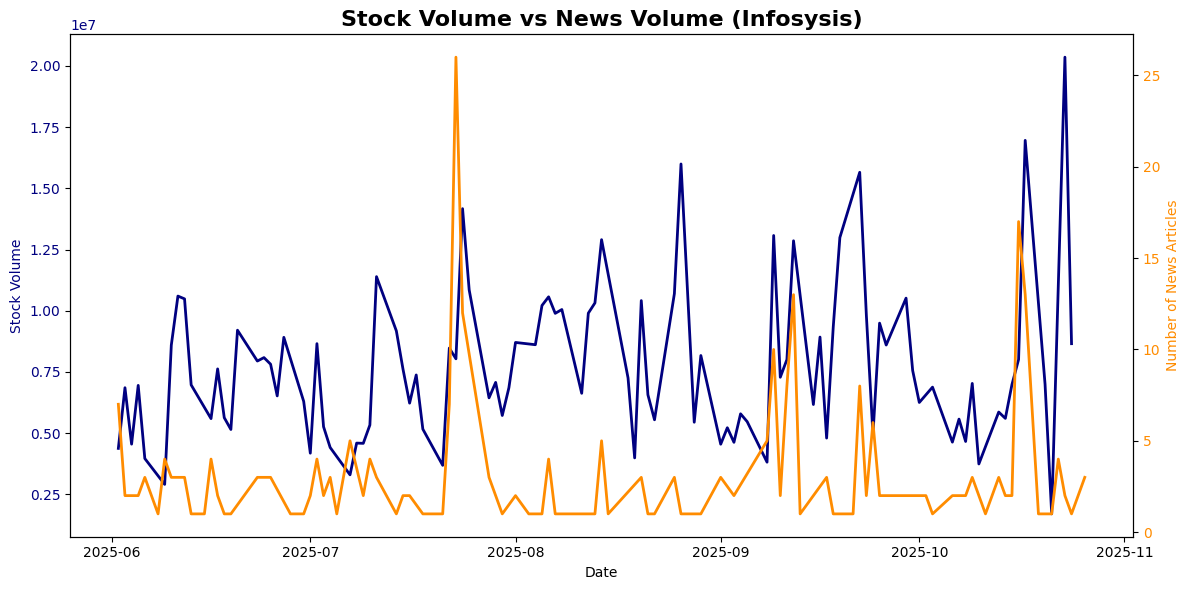

In [16]:
stock_df = pd.read_csv("D:/5TH SEM/stock_sentiment_project/data/raw/stocks/infosys_stock_history.csv")
# plot_news_eda(df_infosys, "Infosys")
# plot_stock_eda(stock_df, "Infosys")
plot_stock_news_relation(stock_df, df_infosys, "Infosysis")


=== Stock + News Relation for SBI ===


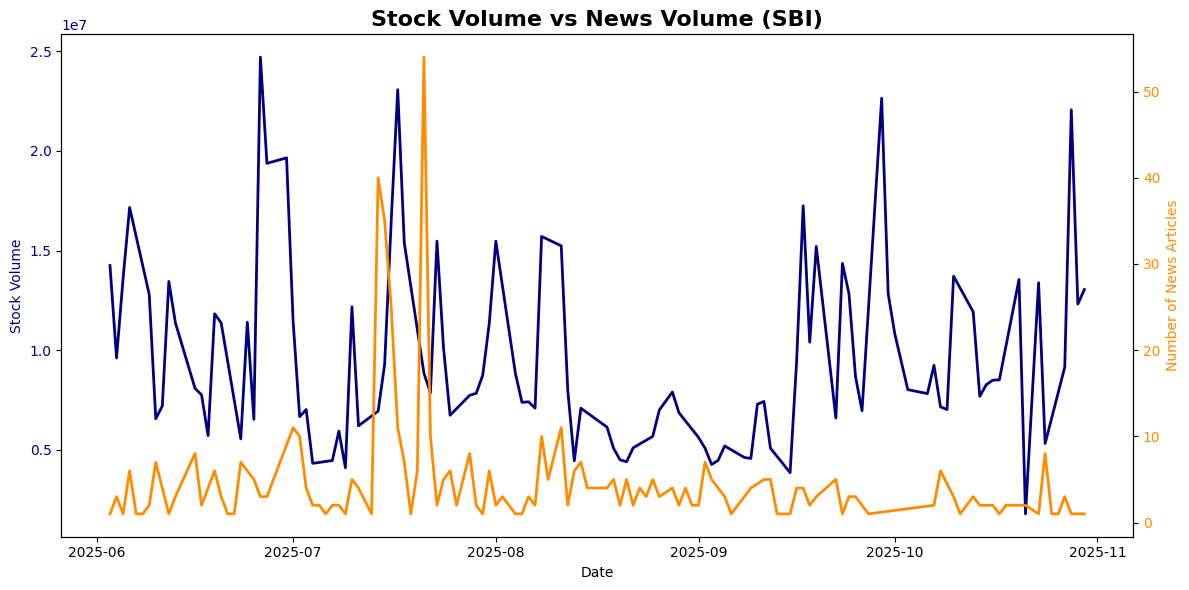

In [17]:
stock_df = pd.read_csv("D:/5TH SEM/stock_sentiment_project/data/raw/stocks/sbi_stock_history.csv")
# plot_news_eda(df_sbi, "SBI")
# plot_stock_eda(stock_df, "SBI")
plot_stock_news_relation(stock_df, df_sbi, "SBI")


=== Stock + News Relation for Reliance ===


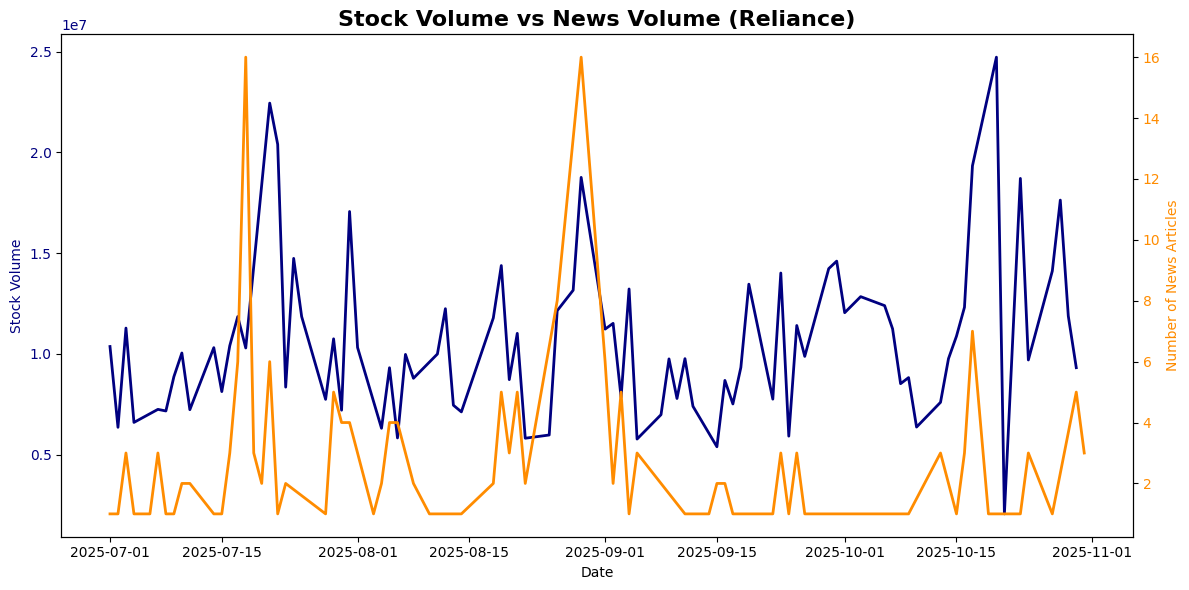

In [18]:
stock_df = pd.read_csv("D:/5TH SEM/stock_sentiment_project/data/raw/stocks/reliance_stock_history.csv")
# plot_news_eda(df_reliance, "Reliance")
# plot_stock_eda(stock_df, "Reliance")
plot_stock_news_relation(stock_df, df_reliance, "Reliance")